In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 1: Fetch Data
start_date = "2010-01-01"
end_date = "2024-12-31"
risk_free_ticker = "^IRX"  # Use the 13-week Treasury yield as a proxy for risk-free rate
market_index_ticker = "^GSPC"  # S&P 500 index
equity_tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA"]  # Replace with desired stock tickers

# Fetch data
risk_free_data = yf.download(risk_free_ticker, start=start_date, end=end_date)["Close"]
market_data = yf.download(market_index_ticker, start=start_date, end=end_date)["Close"]
stock_data = yf.download(equity_tickers, start=start_date, end=end_date)["Close"]

# Step 2: Prepare Data
# Calculate daily returns
market_returns = market_data.pct_change().dropna()
stock_returns = stock_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  5 of 5 completed


In [27]:
stock_returns.head()

Ticker,AAPL,GOOGL,MSFT,NVDA,TSLA
Date,,,,,
2010-06-30,-0.018113,-0.020495,-0.012870,-0.025764,-0.002511
2010-07-01,-0.012126,-0.012271,0.006519,0.016650,-0.078473
2010-07-02,-0.006198,-0.006690,0.004749,-0.012524,-0.125683
2010-07-06,0.006844,-0.001099,0.023635,-0.010732,-0.160937
2010-07-07,0.040381,0.032403,0.020151,0.048323,-0.019243


In [28]:
stock_returns['AAPL'].mean()

np.float64(0.0011083204355458293)

In [29]:
# import matplotlib.pyplot as plt

# # Assuming stock_data['NVDA'] contains the data for NVIDIA's stock
# plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
# plt.plot(stock_data['NVDA'], label='NVIDIA Stock Prices')
# plt.title('NVIDIA Stock Price Over Time')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()

import plotly.graph_objects as go

# Assuming stock_data['NVDA'] contains the data for NVIDIA's stock
fig = go.Figure()

# Add a line plot for NVIDIA stock prices
fig.add_trace(go.Scatter(
    x=stock_data.index,  # Assuming the index contains dates
    y=stock_data['NVDA'],
    mode='lines',
    name='NVIDIA Stock Prices'
))

# Add a line plot for NVIDIA stock prices
fig.add_trace(go.Scatter(
    x=stock_data.index,  # Assuming the index contains dates
    y=stock_data['TSLA'],
    mode='lines',
    name='TSLA Stock Prices'
))

# Customize the layout
fig.update_layout(
    title='NVIDIA Stock Price Over Time',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    showlegend=True
)

# Show the plot
fig.show()

In [30]:
# Import FF Factors
FF_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV')
FF_df['Date'] = pd.to_datetime(FF_df['Date'], format='%Y%m%d')
FF_df['Mkt-RF'] = FF_df['Mkt-RF']/100
FF_df['SMB'] = FF_df['SMB']/100
FF_df['HML'] = FF_df['HML']/100
FF_df['RF'] = FF_df['RF']/100


# Merge the FF Factors to Stocks
stock_returns = stock_returns.merge(FF_df, on = 'Date', how = 'inner')

# print minimal and maximum dates
print(stock_returns['Date'].min(), stock_returns['Date'].max())

2010-06-30 00:00:00 2024-11-29 00:00:00


In [31]:
FF_df.dtypes

Date      datetime64[ns]
Mkt-RF           float64
SMB              float64
HML              float64
RF               float64
dtype: object

In [32]:
FF_df.head()

,Date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1,1926-07-02,0.0045,-0.0033,-0.0006,0.00009
2,1926-07-06,0.0017,0.0030,-0.0039,0.00009
3,1926-07-07,0.0009,-0.0058,0.0002,0.00009
4,1926-07-08,0.0021,-0.0038,0.0019,0.00009


In [33]:
stock_returns.dtypes

Date      datetime64[ns]
AAPL             float64
GOOGL            float64
MSFT             float64
NVDA             float64
TSLA             float64
Mkt-RF           float64
SMB              float64
HML              float64
RF               float64
dtype: object

In [34]:
stock_returns.head()

,Date,AAPL,GOOGL,MSFT,NVDA,TSLA,Mkt-RF,SMB,HML,RF
0,2010-06-30,-0.018113,-0.020495,-0.012870,-0.025764,-0.002511,-0.0098,0.0005,-0.0035,0.00001
1,2010-07-01,-0.012126,-0.012271,0.006519,0.016650,-0.078473,-0.0040,-0.0031,-0.0043,0.00001
2,2010-07-02,-0.006198,-0.006690,0.004749,-0.012524,-0.125683,-0.0050,-0.0030,-0.0044,0.00001
3,2010-07-06,0.006844,-0.001099,0.023635,-0.010732,-0.160937,0.0033,-0.0200,0.0011,0.00001
4,2010-07-07,0.040381,0.032403,0.020151,0.048323,-0.019243,0.0317,0.0005,0.0043,0.00001


In [35]:
stock_returns['AAPL'].median(), stock_returns['Mkt-RF'].median()

(np.float64(0.0009420913515676421), np.float64(0.0007000000000000001))

In [36]:
# is there any missing data
stock_returns[stock_returns['Mkt-RF'].isna()]

,Date,AAPL,GOOGL,MSFT,NVDA,TSLA,Mkt-RF,SMB,HML,RF


# Compare CAPM and Three-Factor Model

In [37]:
# use CAPM model
stock = 'NVDA'

# Stock excess return ~ market excess return
y = stock_returns[stock] - stock_returns['RF']
x = stock_returns['Mkt-RF']
model = sm.OLS(y, x).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())


CAPM model NVDA: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.400
Model:                            OLS   Adj. R-squared (uncentered):              0.400
Method:                 Least Squares   F-statistic:                              2418.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:00:53   Log-Likelihood:                          8662.5
No. Observations:                3630   AIC:                                 -1.732e+04
Df Residuals:                    3629   BIC:                                 -1.732e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [38]:
# Three factor model
# 1.0697 beta of CAPM
y = stock_returns[stock] - stock_returns['RF']
x = stock_returns[['Mkt-RF', 'SMB', 'HML']]
model = sm.OLS(y, x).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())


CAPM model NVDA: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.464
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              1047.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:00:53   Log-Likelihood:                          8868.2
No. Observations:                3630   AIC:                                 -1.773e+04
Df Residuals:                    3627   BIC:                                 -1.771e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

# Accuracy CAPM

In [39]:
# Split train and test
train_test_split = '2024-01-01'
Train_df = stock_returns[stock_returns['Date'] < train_test_split]
Test_df = stock_returns[stock_returns['Date'] >= train_test_split]

In [40]:
# CAPM
# Stock excess return ~ market excess return
y_train = Train_df[stock] - Train_df['RF']
x_train = Train_df['Mkt-RF']
model = sm.OLS(y_train, x_train).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())

CAPM model NVDA: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.406
Model:                            OLS   Adj. R-squared (uncentered):              0.405
Method:                 Least Squares   F-statistic:                              2319.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:00:53   Log-Likelihood:                          8176.7
No. Observations:                3399   AIC:                                 -1.635e+04
Df Residuals:                    3398   BIC:                                 -1.635e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

Mean Absolute Error (MAE): 0.02047644469993713


/tmp/ipykernel_6462/115163375.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



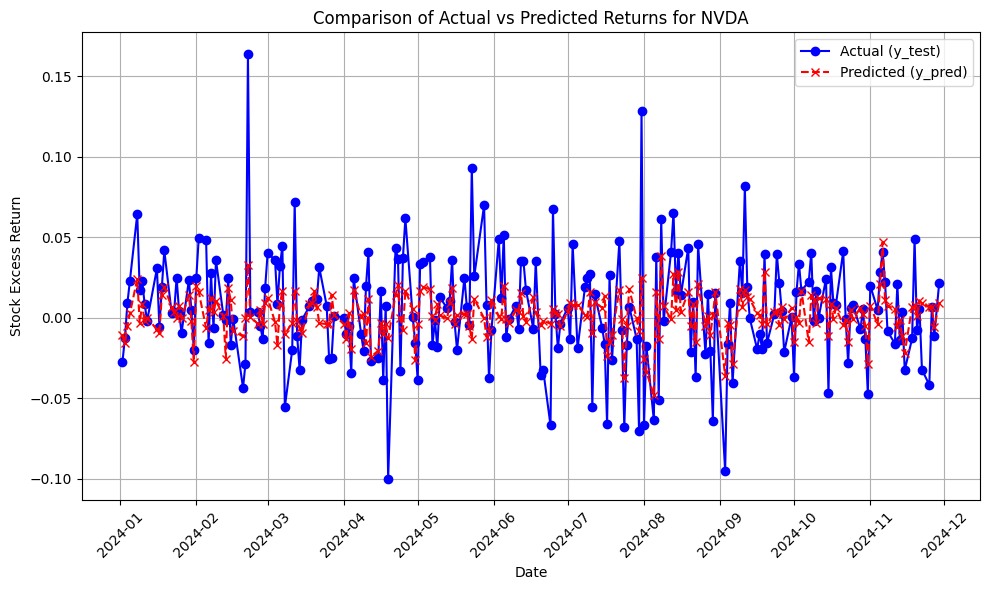

In [41]:
# CAPM test
y_test = Test_df[stock]
x_test = Test_df['Mkt-RF']
y_pred = Test_df['Mkt-RF'] * model.params[0] + Test_df['RF']

# Calculate MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

# Plot y_test vs. y_pred
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], y_test, label='Actual (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], y_pred, label='Predicted (y_pred)', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Comparison of Actual vs Predicted Returns for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Excess Return')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

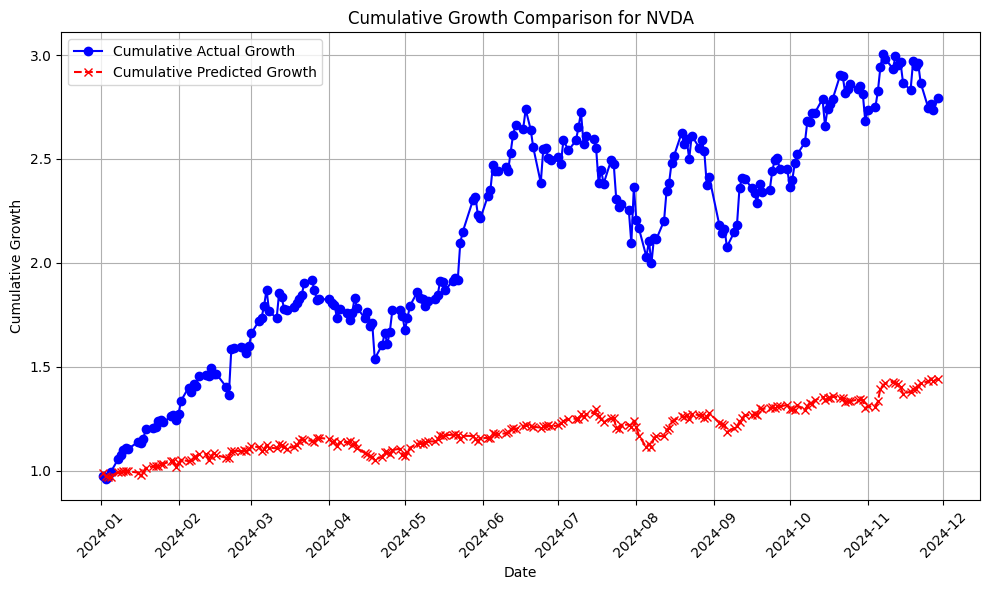

Final Cumulative Growth (Actual): 2.79
Final Cumulative Growth (Predicted): 1.44


In [42]:
# Calculate cumulative returns
cumulative_actual = (1 + y_test).cumprod()
cumulative_predicted = (1 + y_pred).cumprod()

# Plot cumulative growth
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], cumulative_actual, label='Cumulative Actual Growth', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], cumulative_predicted, label='Cumulative Predicted Growth', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Cumulative Growth Comparison for {stock}')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

# Print final cumulative growth values for comparison
print(f"Final Cumulative Growth (Actual): {cumulative_actual.iloc[-1]:.2f}")
print(f"Final Cumulative Growth (Predicted): {cumulative_predicted.iloc[-1]:.2f}")

# Accuracy of Three Factor

In [43]:
# Three factor
# Stock excess return ~ market excess return
y_train = Train_df[stock] - Train_df['RF']
x_train = Train_df[['Mkt-RF', 'SMB', 'HML']]
model = sm.OLS(y_train, x_train).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())

CAPM model NVDA: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.465
Model:                            OLS   Adj. R-squared (uncentered):              0.465
Method:                 Least Squares   F-statistic:                              984.9
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:00:53   Log-Likelihood:                          8356.5
No. Observations:                3399   AIC:                                 -1.671e+04
Df Residuals:                    3396   BIC:                                 -1.669e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

Mean Absolute Error (MAE): 0.018881004681828142


/tmp/ipykernel_6462/182984457.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



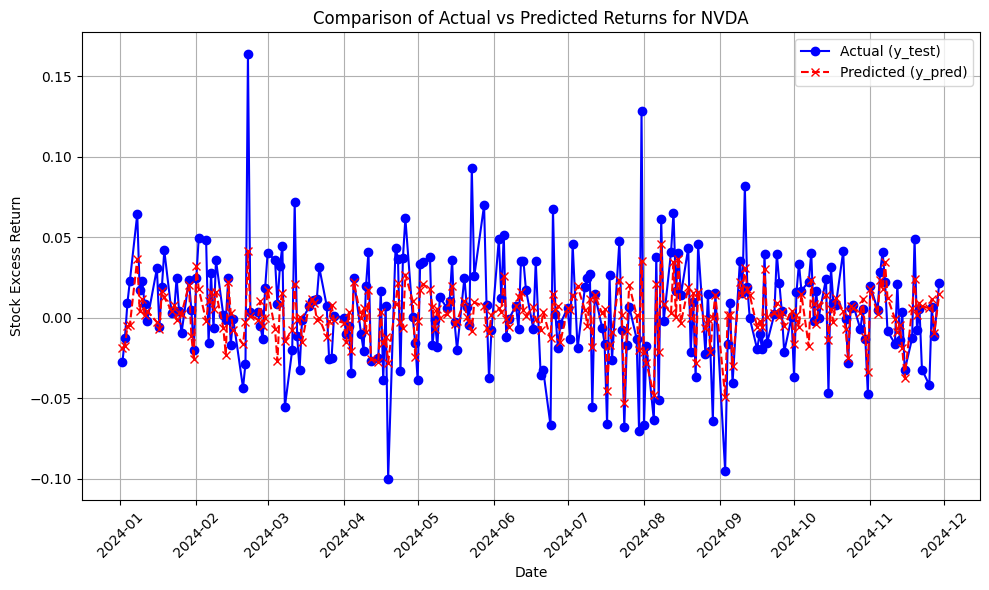

In [44]:
# CAPM test
y_test = Test_df[stock]
x_test = Test_df[['Mkt-RF', 'SMB', 'HML']]
y_pred = Test_df['RF'] + Test_df['Mkt-RF'] * model.params[0] + Test_df['SMB'] * model.params[1] + Test_df['HML'] * model.params[2]

# Calculate MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

# Plot y_test vs. y_pred
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], y_test, label='Actual (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], y_pred, label='Predicted (y_pred)', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Comparison of Actual vs Predicted Returns for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Excess Return')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

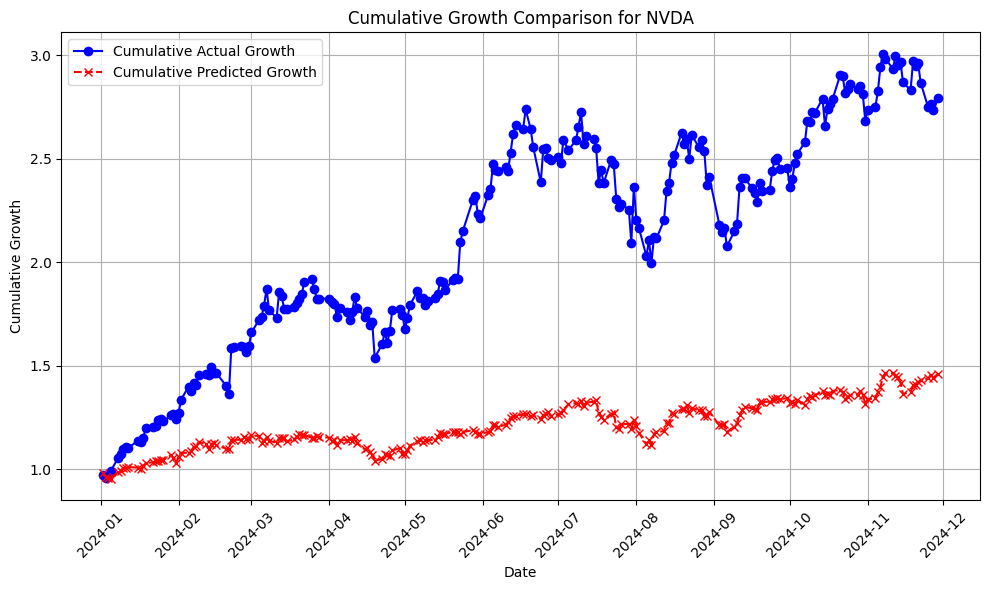

Final Cumulative Growth (Actual): 2.79
Final Cumulative Growth (Predicted): 1.46


In [45]:
# Calculate cumulative returns
cumulative_actual = (1 + y_test).cumprod()
cumulative_predicted = (1 + y_pred).cumprod()

# Plot cumulative growth
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], cumulative_actual, label='Cumulative Actual Growth', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], cumulative_predicted, label='Cumulative Predicted Growth', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Cumulative Growth Comparison for {stock}')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

# Print final cumulative growth values for comparison
print(f"Final Cumulative Growth (Actual): {cumulative_actual.iloc[-1]:.2f}")
print(f"Final Cumulative Growth (Predicted): {cumulative_predicted.iloc[-1]:.2f}")

# Try AI flag

In [46]:
stock_returns['ai_flag'] = 0
stock_returns.loc[stock_returns['Date'] >= '2023-01-01', 'ai_flag'] = 1

In [47]:
stock_returns[stock_returns['Date'] >= '2022-12-30'].head()

,Date,AAPL,GOOGL,MSFT,NVDA,TSLA,Mkt-RF,SMB,HML,RF,ai_flag
3148,2022-12-30,0.002469,-0.002487,-0.004938,0.000753,0.011164,-0.0022,0.0012,-0.0003,0.00016,0
3149,2023-01-03,-0.037405,0.010087,-0.001001,-0.020460,-0.122422,-0.0048,0.0008,-0.0012,0.00017,1
3150,2023-01-04,0.010314,-0.011670,-0.043743,0.030318,0.051249,0.0081,0.0054,0.0005,0.00017,1
3151,2023-01-05,-0.010605,-0.021344,-0.029638,-0.032816,-0.029039,-0.0114,-0.0018,0.0122,0.00017,1
3152,2023-01-06,0.036794,0.013225,0.011785,0.041640,0.024651,0.0221,-0.0006,0.0005,0.00017,1


In [48]:
# use CAPM model
stock = 'NVDA'

# Stock excess return ~ market excess return
y = stock_returns[stock] - stock_returns['RF']
x = stock_returns[['Mkt-RF', 'ai_flag']]
model = sm.OLS(y, x).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())

CAPM model NVDA: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.402
Model:                            OLS   Adj. R-squared (uncentered):              0.402
Method:                 Least Squares   F-statistic:                              1219.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:00:54   Log-Likelihood:                          8668.8
No. Observations:                3630   AIC:                                 -1.733e+04
Df Residuals:                    3628   BIC:                                 -1.732e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [49]:
# Three factor model
# 1.0697 beta of CAPM
y = stock_returns[stock] - stock_returns['RF']
x = stock_returns[['Mkt-RF', 'SMB', 'HML', 'ai_flag']]
model = sm.OLS(y, x).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())

CAPM model NVDA: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.466
Model:                            OLS   Adj. R-squared (uncentered):              0.465
Method:                 Least Squares   F-statistic:                              790.9
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:00:54   Log-Likelihood:                          8874.3
No. Observations:                3630   AIC:                                 -1.774e+04
Df Residuals:                    3626   BIC:                                 -1.772e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

# Train Test with ai flag

In [50]:
# Split train and test
train_test_split = '2024-01-01'
Train_df = stock_returns[stock_returns['Date'] < train_test_split]
Test_df = stock_returns[stock_returns['Date'] >= train_test_split]

CAPM model NVDA: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.407
Model:                            OLS   Adj. R-squared (uncentered):              0.407
Method:                 Least Squares   F-statistic:                              1166.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:00:54   Log-Likelihood:                          8180.7
No. Observations:                3399   AIC:                                 -1.636e+04
Df Residuals:                    3397   BIC:                                 -1.635e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

/tmp/ipykernel_6462/649019017.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



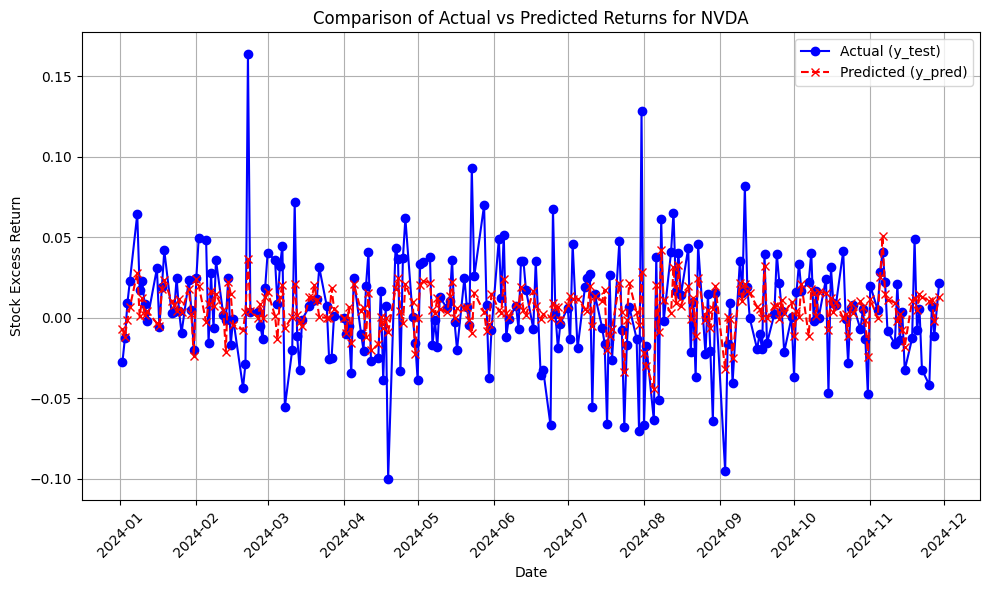

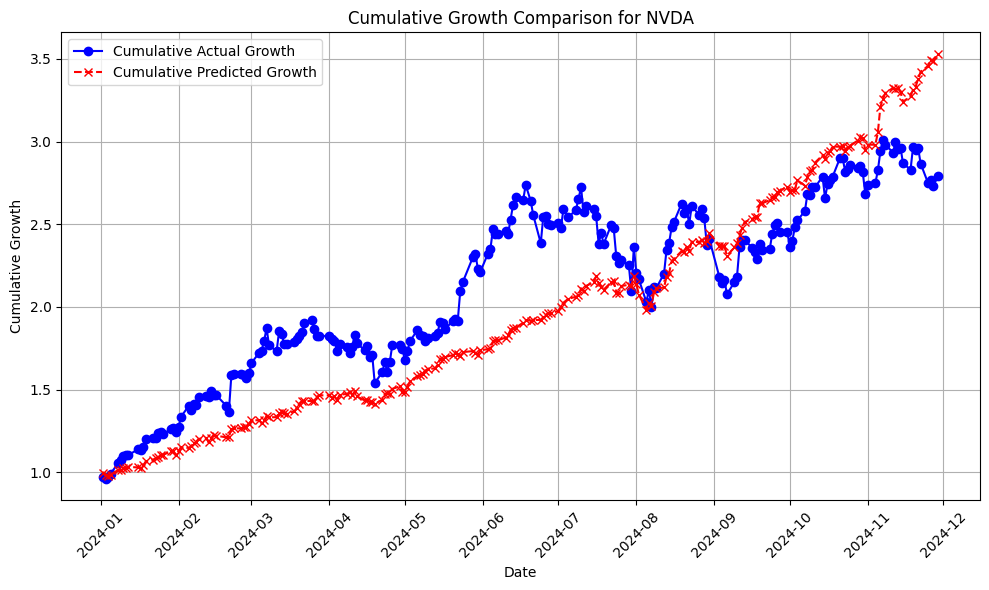

Final Cumulative Growth (Actual): 2.79
Final Cumulative Growth (Predicted): 3.53


In [51]:
# CAPM MODEL WITH AI FLAG
# Stock excess return ~ market excess return
y_train = Train_df[stock] - Train_df['RF']
x_train = Train_df[['Mkt-RF','ai_flag']]
model = sm.OLS(y_train, x_train).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())
# CAPM test
y_test = Test_df[stock]
x_test = Test_df['Mkt-RF']
y_pred = Test_df['Mkt-RF'] * model.params[0] + Test_df['ai_flag'] * model.params[1] + Test_df['RF']

# Calculate MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

# Plot y_test vs. y_pred
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], y_test, label='Actual (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], y_pred, label='Predicted (y_pred)', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Comparison of Actual vs Predicted Returns for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Excess Return')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()
# Calculate cumulative returns
cumulative_actual = (1 + y_test).cumprod()
cumulative_predicted = (1 + y_pred).cumprod()

# Plot cumulative growth
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], cumulative_actual, label='Cumulative Actual Growth', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], cumulative_predicted, label='Cumulative Predicted Growth', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Cumulative Growth Comparison for {stock}')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

# Print final cumulative growth values for comparison
print(f"Final Cumulative Growth (Actual): {cumulative_actual.iloc[-1]:.2f}")
print(f"Final Cumulative Growth (Predicted): {cumulative_predicted.iloc[-1]:.2f}")

CAPM model NVDA: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.466
Model:                            OLS   Adj. R-squared (uncentered):              0.466
Method:                 Least Squares   F-statistic:                              741.9
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:00:55   Log-Likelihood:                          8360.2
No. Observations:                3399   AIC:                                 -1.671e+04
Df Residuals:                    3395   BIC:                                 -1.669e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

/tmp/ipykernel_6462/3969255052.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



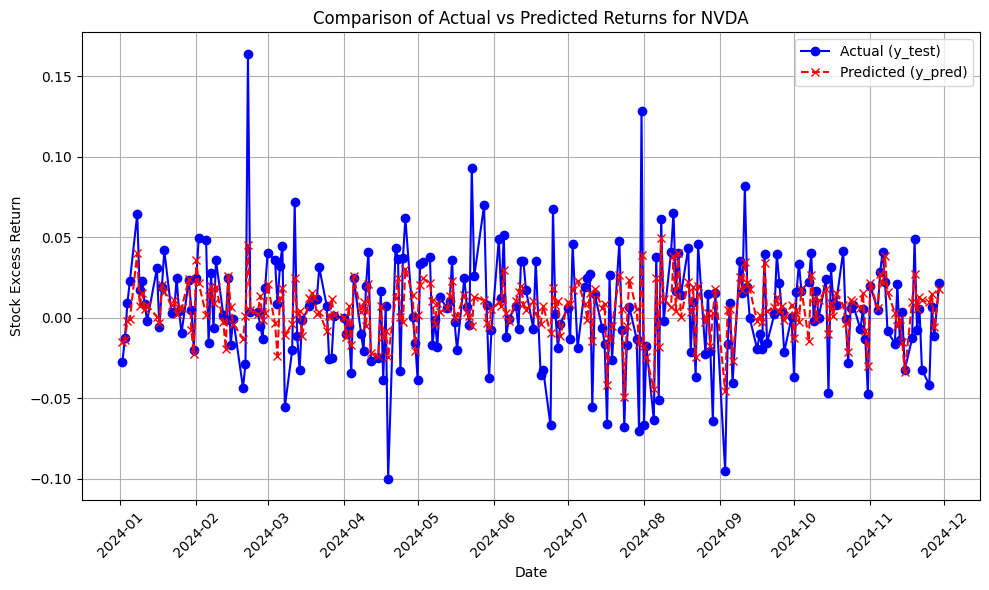

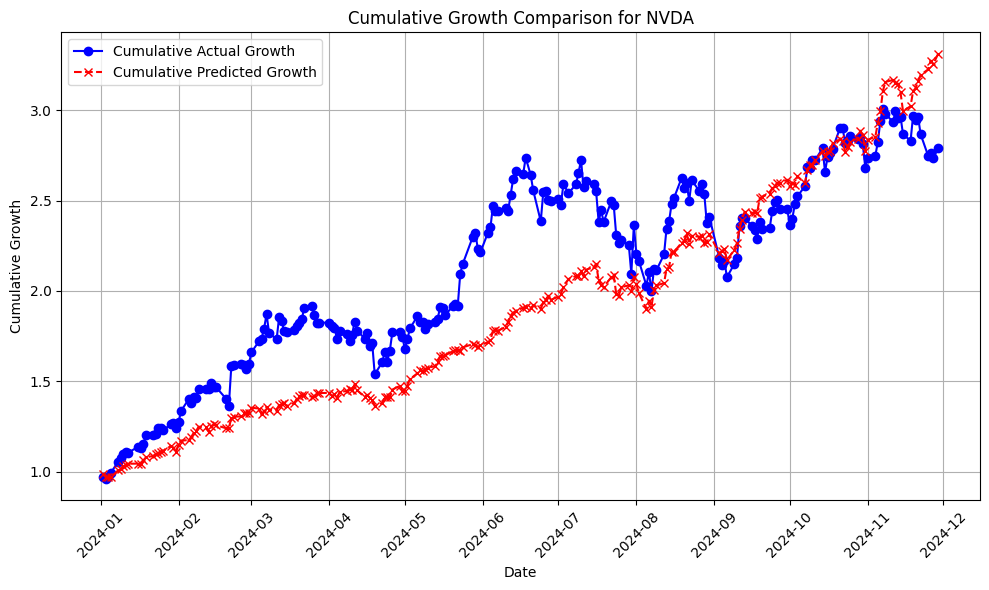

Final Cumulative Growth (Actual): 2.79
Final Cumulative Growth (Predicted): 3.31


In [52]:
# CAPM MODEL WITH AI FLAG
# Stock excess return ~ market excess return
y_train = Train_df[stock] - Train_df['RF']
x_train = Train_df[['Mkt-RF', 'SMB', 'HML','ai_flag']]
model = sm.OLS(y_train, x_train).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())
# CAPM test
y_test = Test_df[stock]
x_test = Test_df['Mkt-RF']
y_pred = Test_df['Mkt-RF'] * model.params[0] + Test_df['SMB'] * model.params[1] + Test_df['HML'] * model.params[2] + Test_df['ai_flag'] * model.params[3] + Test_df['RF']

# Calculate MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

# Plot y_test vs. y_pred
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], y_test, label='Actual (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], y_pred, label='Predicted (y_pred)', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Comparison of Actual vs Predicted Returns for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Excess Return')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()
# Calculate cumulative returns
cumulative_actual = (1 + y_test).cumprod()
cumulative_predicted = (1 + y_pred).cumprod()

# Plot cumulative growth
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], cumulative_actual, label='Cumulative Actual Growth', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], cumulative_predicted, label='Cumulative Predicted Growth', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Cumulative Growth Comparison for {stock}')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

# Print final cumulative growth values for comparison
print(f"Final Cumulative Growth (Actual): {cumulative_actual.iloc[-1]:.2f}")
print(f"Final Cumulative Growth (Predicted): {cumulative_predicted.iloc[-1]:.2f}")